In [1]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
plt.rc('axes', labelsize=15)

import seaborn as sns

import tqdm

import numpy as np
import pandas as pd
import torch
import random 

from src import config, data, training_utils
from src.models import base_models
from src.models import slot_attention

import torchvision.transforms as transforms

from utils.heatmap_utils import *

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
default_cfg = config.SpriteWorldConfig()

In [4]:
# ("x", "y", "shape", "scale", "angle",  "c0", "c1", "c2")

In [5]:
initial_sample = torch.tensor([[0.4504, 0.5, 0.0000, 0.1, 0.0000, 0.42, 0.62, 0.72],
                               [0.7401, 0.5, 0.0000, 0.1, 0.0000, 0.38, 0.58, 0.68]])

In [6]:
traversed_dataset_4 = create_traversed_dataset(initial_sample, n_steps=4)

Generating images (sampling: random): 100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 160.90it/s]


In [7]:
x_4, y_4 = get_binary_id_mask(traversed_dataset_4, size=4)

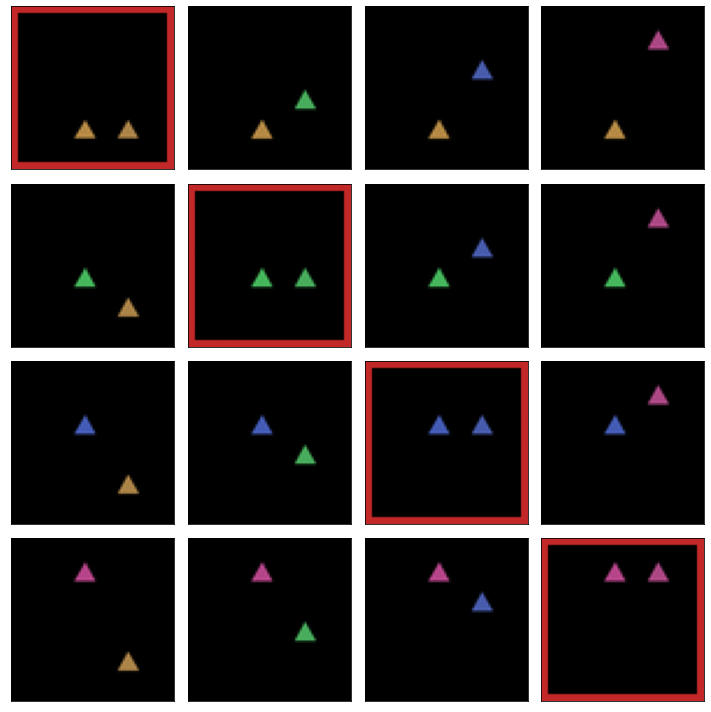

In [8]:
n_steps = 4
plot_dataset_images(traversed_dataset_4, rows=n_steps, cols=n_steps, pred=False, id_mask=(x_4, y_4))

In [9]:
min_offset = torch.FloatTensor(
    [rng.min for rng in default_cfg.get_ranges().values()]
).reshape(1, 1, -1)
scale = torch.FloatTensor(
    [rng.max - rng.min for rng in default_cfg.get_ranges().values()]
).reshape(1, 1, -1)
scale[scale == 0] = 1
    
train_loader = torch.utils.data.DataLoader(
    traversed_dataset_4,
    batch_size=len(traversed_dataset_4),
    shuffle=False,
    collate_fn=lambda b: training_utils.collate_fn_normalizer(b, min_offset, scale),
)

In [10]:
model = base_models.SlotMLPAdditive(3, 2, 8)

In [11]:
device="cuda"
encoder = slot_attention.SlotAttentionEncoder(
            resolution=(64, 64), hid_dim=16, device=device
        ).to(device)

decoder = slot_attention.SlotAttentionDecoder(
    hid_dim=16, resolution=(64, 64), device=device
)
slotattention_model = slot_attention.SlotAttentionAutoEncoder(
    encoder=encoder,
    decoder=decoder,
    num_slots=2,
    num_iterations=3,
    hid_dim=16,
    device=device,
).to(device)


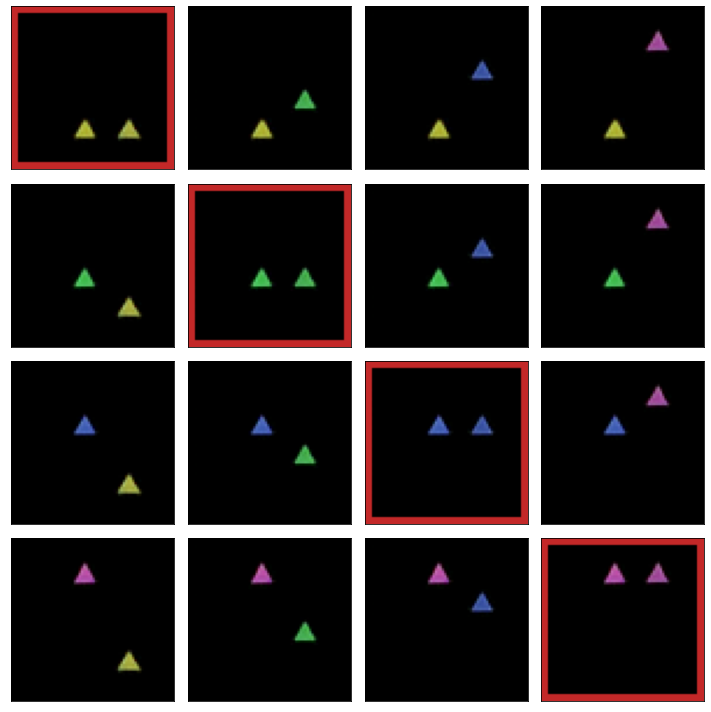

In [12]:
model.load_state_dict(torch.load("id_model.pt"))
model.to("cpu")
model.eval()

make_pred_and_plot(model, train_loader, device="cpu", decoder=True, name="decoder", id_mask=(x_4, y_4))

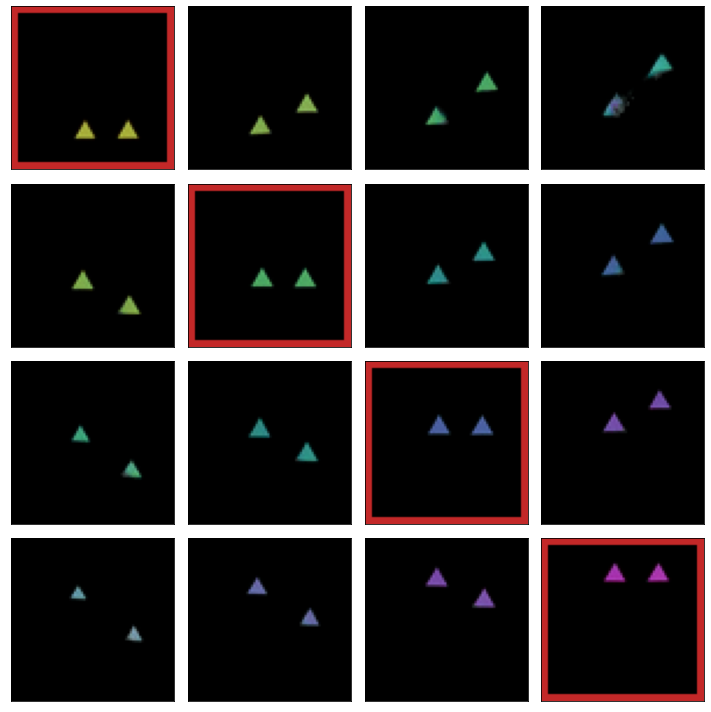

In [13]:
slotattention_model.load_state_dict(torch.load("slotattention.pt"))
slotattention_model.eval()

make_pred_and_plot(slotattention_model, train_loader, device="cuda", decoder=False, name="slotattention", id_mask=(x_4, y_4))

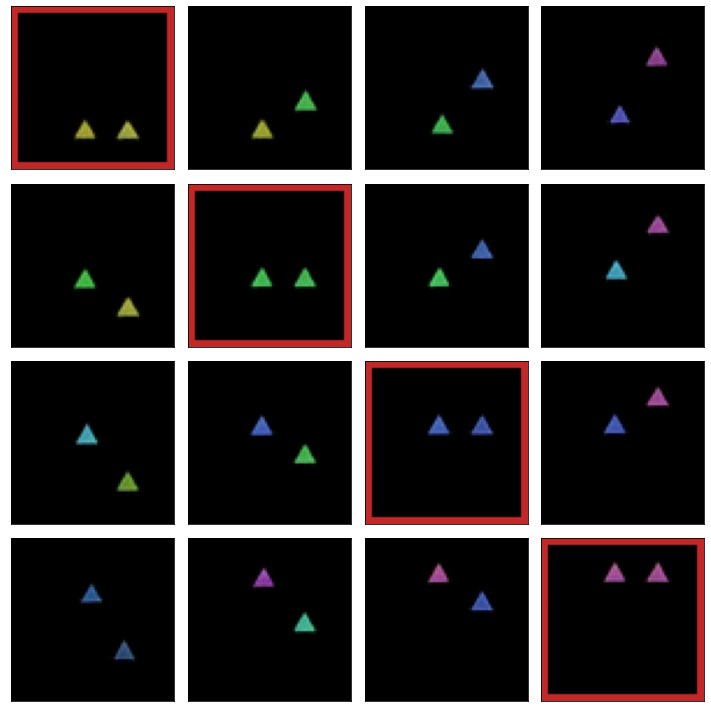

In [14]:
model.load_state_dict(torch.load("id_model.pt"))
model.cpu()
model.eval()

make_pred_and_plot(model, train_loader, device="cpu", decoder=False, name="encoder+decoder", id_mask=(x_4, y_4))

In [15]:
traversed_dataset = create_traversed_dataset(initial_sample, n_steps=100)
heatmap_loader = torch.utils.data.DataLoader(
    traversed_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda b: training_utils.collate_fn_normalizer(b, min_offset, scale),
) 

Generating images (sampling: random): 100%|█████████████████████████████████████| 10000/10000 [01:00<00:00, 165.75it/s]


In [16]:
x, y = get_binary_id_mask(traversed_dataset)

In [17]:
loss_slotattention = predict_for_heatmap(slotattention_model, "SlotAttention_0.01_best_id_model.pt", heatmap_loader, decoder=False)

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:57<00:00, 10.82it/s]


In [18]:
loss_ood = predict_for_heatmap(model, "ood_model.pt", heatmap_loader, decoder=False, device="cpu")
loss_ood_decoder = predict_for_heatmap(model, "ood_model.pt", heatmap_loader, decoder=True, device="cpu")

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [01:00<00:00, 10.33it/s]


In [19]:
loss_id = predict_for_heatmap(model, "id_model.pt", heatmap_loader, decoder=False, device="cpu")
loss_id_decoder = predict_for_heatmap(model, "id_model.pt", heatmap_loader, decoder=True, device="cpu")

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.63it/s]


In [20]:
# code for outlining ID samples region
id_mtx = np.zeros((100, 100))
for (i, j) in list(zip(x, y)):
    id_mtx[i, j] = 1
    
x_line_left = []
y_line_left = []
x_line_right = [0.5]
y_line_right = [0.5]
for i in range(100):
    for j in range(100):
        if j != 99 and id_mtx[i, j] and id_mtx[i, j+1] == 0 :
            x_line_right.append(i + 0.5)
            y_line_right.append(j + 0.5)
        if  id_mtx[i, j] and id_mtx[i, j-1] == 0:
            x_line_left.append(i+ 0.5)
            y_line_left.append(j+ 0.5)

x_line_right.append(78 + 0.5)
y_line_right.append(99 + 0.5)
x_line_right.append(99 + 0.5)
y_line_right.append(99 + 0.5)
x_line_left.append(99 + 0.5)
y_line_left.append(99 + 0.5)

In [21]:
def plot_heatmap(loss_arrays, left_line, right_line, shape=100, figsize=(12, 5)):
    f, axs = plt.subplots(1, len(loss_arrays) + 1, gridspec_kw={'width_ratios':[1]*len(loss_arrays) + [0.08]}, figsize=figsize)
    max_ = max(max(np.array(loss_i)) for loss_i in loss_arrays)
    gs = []

    x_line_left, y_line_left = left_line
    x_line_right, y_line_right = right_line
    for i in range(len(loss_arrays)):
        axs[i].scatter(0, 0, s=shape, alpha=1, marker="s", facecolors="none", edgecolors="#C32828", linewidth=1, label="ID samples")
        last_heatmap = i == (len(loss_arrays) - 1)
        kwargs = {}
        if last_heatmap:
            kwargs["cbar_ax"] = axs[i+1]
        gs.append(sns.heatmap(np.array(loss_arrays[i]).reshape(shape, shape) / max_, vmin=0, vmax=1, 
                 cmap="icefire",
                 cbar=last_heatmap, ax=axs[i], **kwargs))

        # axs[0].scatter(x, y, s=5, alpha=0.5, marker="s", facecolors="none", edgecolors="#C32828", linewidth=0.2)
        axs[i].plot(x_line_left, y_line_left, c="#C32828")
        axs[i].plot(x_line_right, y_line_right, c="#C32828")
        axs[i].legend(loc='lower right')
        gs[i].set_xticks([])
        gs[i].set_yticks([])

    plt.savefig(f"heatmap.svg")
    plt.show()

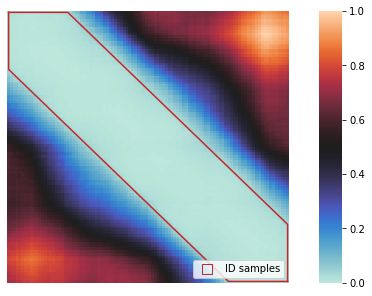

In [22]:
plot_heatmap([loss_slotattention], (x_line_left, y_line_left), (x_line_right, y_line_right), figsize=(6, 5))

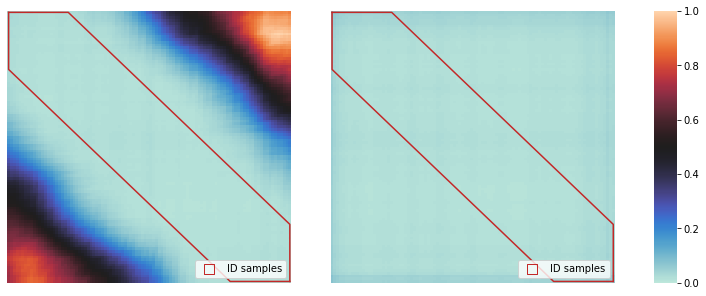

In [23]:
plot_heatmap([loss_id, loss_id_decoder], (x_line_left, y_line_left), (x_line_right, y_line_right), figsize=(12, 5))

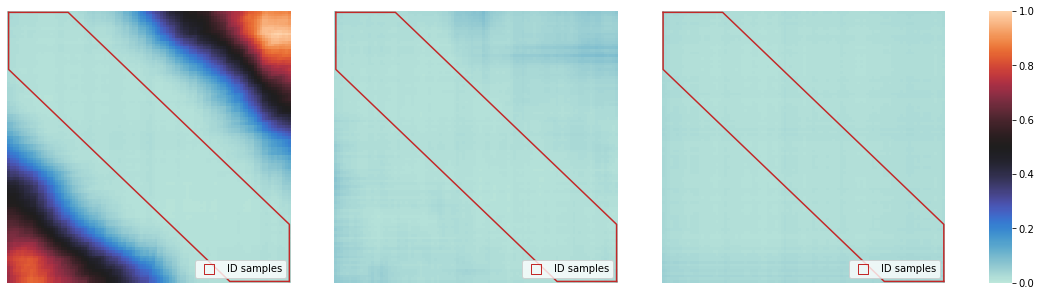

In [24]:
plot_heatmap([loss_id, loss_ood, loss_ood_decoder], (x_line_left, y_line_left), (x_line_right, y_line_right), figsize=(18, 5))